In [3]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 1

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K


In [4]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10
    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features


In [5]:
path='C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet/auto_data/'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

In [6]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))



(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# Audio Model

In [7]:
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                       decay=0.0, amsgrad=False)

num_classes = 7


def build_scrath_sound_model_layers_diff():
    
    print('building the model ... ')
    
    model = Sequential()
    model.add(Dense(256, input_shape=(193,), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])
    return model

In [8]:
sound_model = build_scrath_sound_model_layers_diff()

building the model ... 


In [9]:
sound_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               49664     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
OUTPUT (Dense)               (None, 7)                 455       
Total params: 157,063
Trainable params: 157,063
Non-trainable params: 0
__________________________________________________

In [10]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet/'


from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)

In [11]:
import time
start_time = time.time()

epochs = 500
batch_size=128

learning_hist=sound_model.fit(Features_sound, Labels,
                    verbose=0,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer,TqdmCallback(verbose=2)],
                    validation_data=(Features_sound2,Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.30700, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.30700 to 0.33900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.33900 to 0.48400, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy did not improve from 0.48400


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.48400 to 0.57100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.57100 to 0.68300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy improved from 0.68300 to 0.73300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy did not improve from 0.73300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy improved from 0.73300 to 0.77900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy did not improve from 0.77900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy did not improve from 0.77900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.77900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy improved from 0.77900 to 0.82700, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy did not improve from 0.82700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy did not improve from 0.82700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy did not improve from 0.82700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy did not improve from 0.82700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy improved from 0.82700 to 0.83600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy did not improve from 0.83600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy improved from 0.83600 to 0.83900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy did not improve from 0.83900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy did not improve from 0.83900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy improved from 0.83900 to 0.85600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy improved from 0.85600 to 0.86300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy did not improve from 0.86300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy improved from 0.86300 to 0.86600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy improved from 0.86600 to 0.87900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00028: val_accuracy improved from 0.87900 to 0.89100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00029: val_accuracy did not improve from 0.89100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00030: val_accuracy did not improve from 0.89100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00031: val_accuracy did not improve from 0.89100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00032: val_accuracy did not improve from 0.89100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00033: val_accuracy did not improve from 0.89100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00034: val_accuracy improved from 0.89100 to 0.89900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00035: val_accuracy improved from 0.89900 to 0.91300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00036: val_accuracy did not improve from 0.91300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00037: val_accuracy improved from 0.91300 to 0.91600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00038: val_accuracy did not improve from 0.91600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00039: val_accuracy did not improve from 0.91600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00040: val_accuracy improved from 0.91600 to 0.92700, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00041: val_accuracy did not improve from 0.92700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00042: val_accuracy did not improve from 0.92700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00043: val_accuracy did not improve from 0.92700


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00044: val_accuracy improved from 0.92700 to 0.94600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00045: val_accuracy did not improve from 0.94600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00046: val_accuracy did not improve from 0.94600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00047: val_accuracy did not improve from 0.94600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00048: val_accuracy did not improve from 0.94600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00049: val_accuracy did not improve from 0.94600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00050: val_accuracy improved from 0.94600 to 0.95100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00051: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00052: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00053: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00054: val_accuracy improved from 0.95100 to 0.95800, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00055: val_accuracy did not improve from 0.95800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00056: val_accuracy did not improve from 0.95800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00057: val_accuracy did not improve from 0.95800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00058: val_accuracy did not improve from 0.95800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00059: val_accuracy did not improve from 0.95800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00060: val_accuracy did not improve from 0.95800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00061: val_accuracy improved from 0.95800 to 0.96600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00062: val_accuracy did not improve from 0.96600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00063: val_accuracy did not improve from 0.96600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00064: val_accuracy did not improve from 0.96600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00065: val_accuracy did not improve from 0.96600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00066: val_accuracy did not improve from 0.96600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00067: val_accuracy did not improve from 0.96600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00068: val_accuracy improved from 0.96600 to 0.97100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00069: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00070: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00071: val_accuracy improved from 0.97100 to 0.97300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00072: val_accuracy did not improve from 0.97300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00073: val_accuracy did not improve from 0.97300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00074: val_accuracy did not improve from 0.97300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00075: val_accuracy did not improve from 0.97300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00076: val_accuracy did not improve from 0.97300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00077: val_accuracy improved from 0.97300 to 0.97500, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00078: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00079: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00080: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00081: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00082: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00083: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00084: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00085: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00086: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00087: val_accuracy did not improve from 0.97500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00088: val_accuracy improved from 0.97500 to 0.98000, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00089: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00090: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00091: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00092: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00093: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00094: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00095: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00096: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00097: val_accuracy did not improve from 0.98000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00098: val_accuracy improved from 0.98000 to 0.98300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00099: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00100: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00101: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00102: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00103: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00104: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00105: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00106: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00107: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00108: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00109: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00110: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00111: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00112: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00113: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00114: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00115: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00116: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00117: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00118: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00119: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00120: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00121: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00122: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00123: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00124: val_accuracy did not improve from 0.98300


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00125: val_accuracy improved from 0.98300 to 0.98400, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00126: val_accuracy did not improve from 0.98400


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00127: val_accuracy improved from 0.98400 to 0.98500, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00128: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00129: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00130: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00131: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00132: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00133: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00134: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00135: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00136: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00137: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00138: val_accuracy did not improve from 0.98500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00139: val_accuracy improved from 0.98500 to 0.98800, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00140: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00141: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00142: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00143: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00144: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00145: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00146: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00147: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00148: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00149: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00150: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00151: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00152: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00153: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00154: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00155: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00156: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00157: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00158: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00159: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00160: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00161: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00162: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00163: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00164: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00165: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00166: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00167: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00168: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00169: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00170: val_accuracy did not improve from 0.98800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00171: val_accuracy improved from 0.98800 to 0.98900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00172: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00173: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00174: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00175: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00176: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00177: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00178: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00179: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00180: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00181: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00182: val_accuracy did not improve from 0.98900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00183: val_accuracy improved from 0.98900 to 0.99000, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00184: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00185: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00186: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00187: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00188: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00189: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00190: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00191: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00192: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00193: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00194: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00195: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00196: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00197: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00198: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00199: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00200: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00201: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00202: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00203: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00204: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00205: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00206: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00207: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00208: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00209: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00210: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00211: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00212: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00213: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00214: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00215: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00216: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00217: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00218: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00219: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00220: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00221: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00222: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00223: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00224: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00225: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00226: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00227: val_accuracy did not improve from 0.99000


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00228: val_accuracy improved from 0.99000 to 0.99100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00229: val_accuracy did not improve from 0.99100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00230: val_accuracy did not improve from 0.99100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00231: val_accuracy improved from 0.99100 to 0.99200, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00232: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00233: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00234: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00235: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00236: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00237: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00238: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00239: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00240: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00241: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00242: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00243: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00244: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00245: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00246: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00247: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00248: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00249: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00250: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00251: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00252: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00253: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00254: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00255: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00256: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00257: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00258: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00259: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00260: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00261: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00262: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00263: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00264: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00265: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00266: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00267: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00268: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00269: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00270: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00271: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00272: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00273: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00274: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00275: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00276: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00277: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00278: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00279: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00280: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00281: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00282: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00283: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00284: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00285: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00286: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00287: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00288: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00289: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00290: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00291: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00292: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00293: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00294: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00295: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00296: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00297: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00298: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00299: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00300: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00301: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00302: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00303: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00304: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00305: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00306: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00307: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00308: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00309: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00310: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00311: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00312: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00313: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00314: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00315: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00316: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00317: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00318: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00319: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00320: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00321: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00322: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00323: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00324: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00325: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00326: val_accuracy did not improve from 0.99200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00327: val_accuracy improved from 0.99200 to 0.99500, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00328: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00329: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00330: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00331: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00332: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00333: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00334: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00335: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00336: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00337: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00338: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00339: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00340: val_accuracy did not improve from 0.99500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00341: val_accuracy improved from 0.99500 to 0.99600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00342: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00343: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00344: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00345: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00346: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00347: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00348: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00349: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00350: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00351: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00352: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00353: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00354: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00355: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00356: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00357: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00358: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00359: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00360: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00361: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00362: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00363: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00364: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00365: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00366: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00367: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00368: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00369: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00370: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00371: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00372: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00373: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00374: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00375: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00376: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00377: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00378: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00379: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00380: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00381: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00382: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00383: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00384: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00385: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00386: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00387: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00388: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00389: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00390: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00391: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00392: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00393: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00394: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00395: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00396: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00397: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00398: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00399: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00400: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00401: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00402: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00403: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00404: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00405: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00406: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00407: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00408: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00409: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00410: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00411: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00412: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00413: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00414: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00415: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00416: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00417: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00418: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00419: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00420: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00421: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00422: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00423: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00424: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00425: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00426: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00427: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00428: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00429: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00430: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00431: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00432: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00433: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00434: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00435: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00436: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00437: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00438: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00439: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00440: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00441: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00442: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00443: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00444: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00445: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00446: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00447: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00448: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00449: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00450: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00451: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00452: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00453: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00454: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00455: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00456: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00457: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00458: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00459: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00460: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00461: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00462: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00463: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00464: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00465: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00466: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00467: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00468: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00469: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00470: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00471: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00472: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00473: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00474: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00475: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00476: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00477: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00478: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00479: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00480: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00481: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00482: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00483: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00484: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00485: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00486: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00487: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00488: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00489: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00490: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00491: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00492: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00493: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00494: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00495: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00496: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00497: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00498: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00499: val_accuracy did not improve from 0.99600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00500: val_accuracy did not improve from 0.99600
---Time 102.49741625785828 seconds ---


In [12]:
from keras.models import load_model

sound_model = load_model(model_path)

In [13]:
#Train Accuracy
sound_model.evaluate(Features_sound,Labels)

157/157 [==============================] - 0s 2ms/step - loss: 4.7496e-04 - accuracy: 1.0000


[0.00047495533362962306, 1.0]

In [14]:
#valid Accuracy
sound_model.evaluate(Features_sound2,Labels2)

32/32 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9960


[0.020786629989743233, 0.9959999918937683]

In [15]:
#Test Accuracy
sound_model.evaluate(Features_sound3,Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.3291 - accuracy: 0.9339


[0.3290875256061554, 0.933914303779602]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


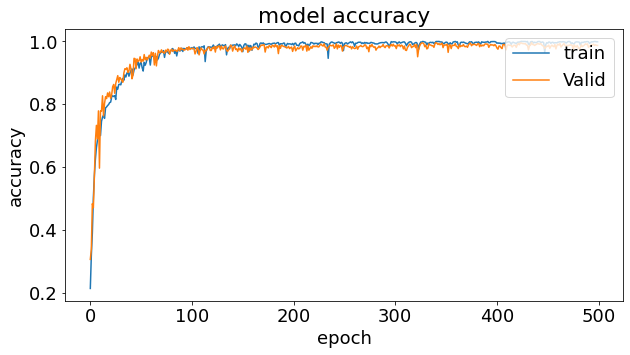

In [16]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()


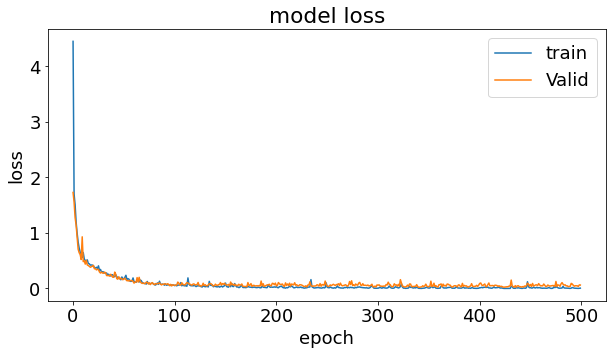

In [17]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()